# EX19. 난 스케치를 할 테니 너는 채색을 하거라.

******************************

> 평가문항
> 1) pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.

> 2) pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.

> 3) 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.



************
### 프로젝트 필수 사항

- 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
- 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.

- 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
- 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
- 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.



*************************

In [34]:
import tensorflow as tf

import os
import time
import cv2
import numpy as np

from glob import glob
from matplotlib import pyplot as plt
import matplotlib.image as image
from IPython import display

In [35]:
# 학습 데이터 샘플 수
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [36]:
# 검증 데이터 샘플 수
import os

data_path2 = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'
print("number of val examples :", len(os.listdir(data_path2)))

number of val examples : 5


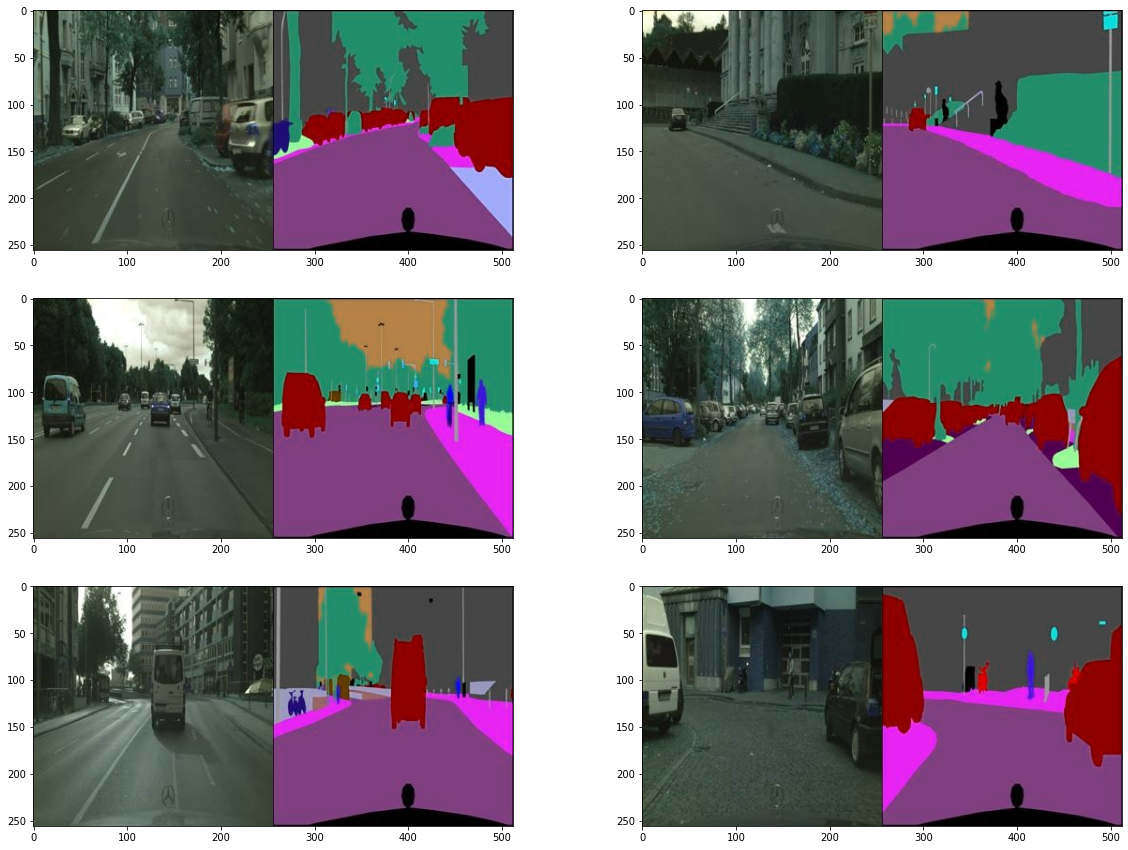

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [38]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 256x512의 RGB 이미지

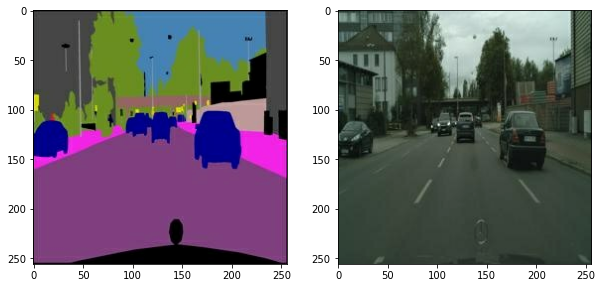

In [39]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

- augmentation 적용

In [40]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(input_image, real_image):
    stacked = tf.concat([input_image, real_image], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

- 회전 변환 및 이미지 축소 적용

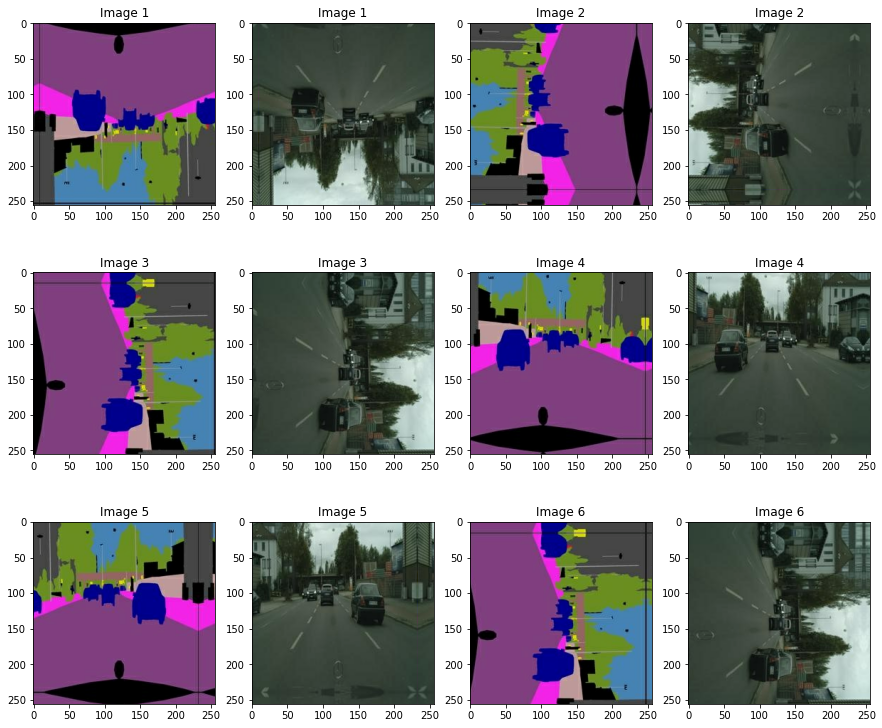

In [41]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_real = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

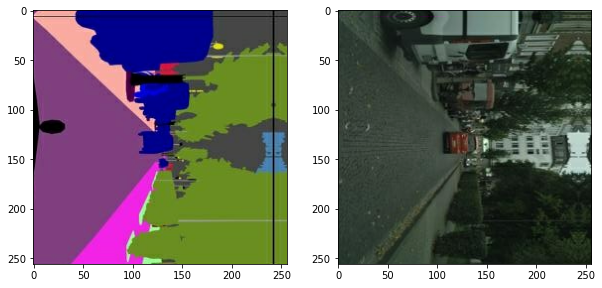

In [42]:
from tensorflow import data

def get_train(img_path):
    input_image, real_image = load_img(img_path)
    input_image, real_image = apply_augmentation(input_image, real_image)
    return input_image, real_image

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, real_image = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_image[0].astype(np.uint8))

## Generator

- U-net Generator 사용
    - 인코더와 디코더를 skip connection 으로 연결한 모델. 

In [43]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [44]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- 모델 크기 확인

In [45]:
UNetGenerator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_40 (EncodeBlock)   (None, 128, 128, 64) 3072        input_7[0][0]                    
__________________________________________________________________________________________________
encode_block_41 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_40[0][0]            
__________________________________________________________________________________________________
encode_block_42 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_41[0][0]            
____________________________________________________________________________________________

## Discriminator

In [46]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [47]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # for loop로 간편하게 블록 만들기
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

- 모델 크기 확인

In [48]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 256, 256, 6)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
disc_block_35 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_28[0][0]       

- 임의의 크기 입력을 넣어서 출력 결과를 시각화

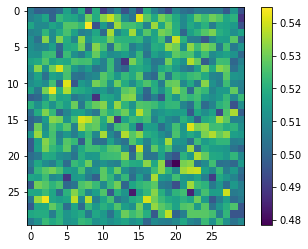

In [49]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 모델 학습 및 테스트

- 손실 함수 정의

In [50]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- 최적화 함수 정의

In [57]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [58]:
@tf.function
def train_step(input_image, real_image):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_output = generator(input_image, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, real_image, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, real_image, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

- EPOCHS은 기본이 300이라고....

In [20]:
EPOCHS = 300

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.9424                     
L1_loss:0.2250                     
Discriminator_loss:0.9522

EPOCH[1] - STEP[200]                     
Generator_loss:1.3078                     
L1_loss:0.2093                     
Discriminator_loss:0.8884

EPOCH[2] - STEP[100]                     
Generator_loss:0.2940                     
L1_loss:0.1928                     
Discriminator_loss:1.7680

EPOCH[2] - STEP[200]                     
Generator_loss:2.1950                     
L1_loss:0.1566                     
Discriminator_loss:0.4230

EPOCH[3] - STEP[100]                     
Generator_loss:0.9111                     
L1_loss:0.1659                     
Discriminator_loss:0.7672

EPOCH[3] - STEP[200]                     
Generator_loss:1.4866                     
L1_loss:0.2218                     
Discriminator_loss:0.4137

EPOCH[4] - STEP[100]                     
Generator_loss:2.1472                     
L1_loss:0.2132             

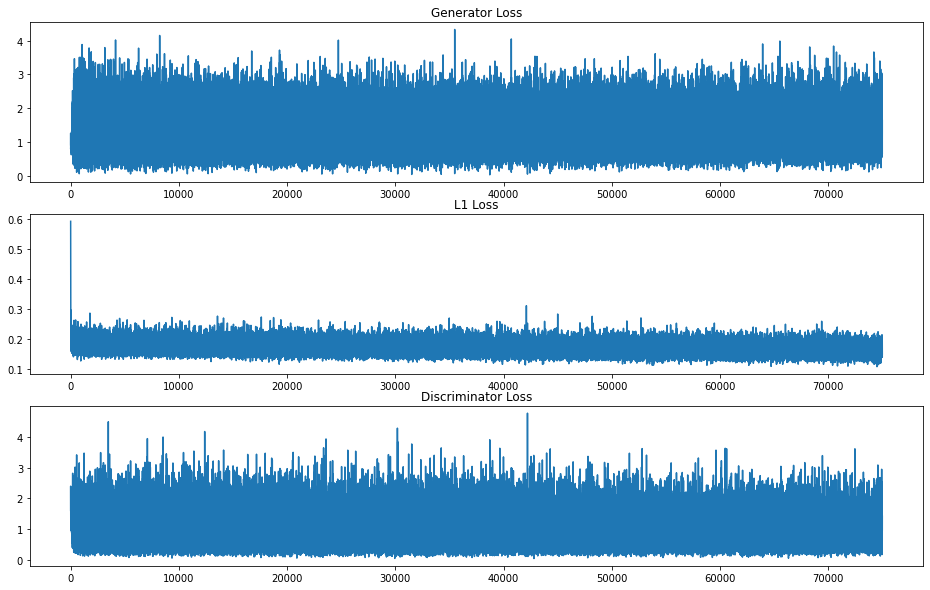

In [21]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

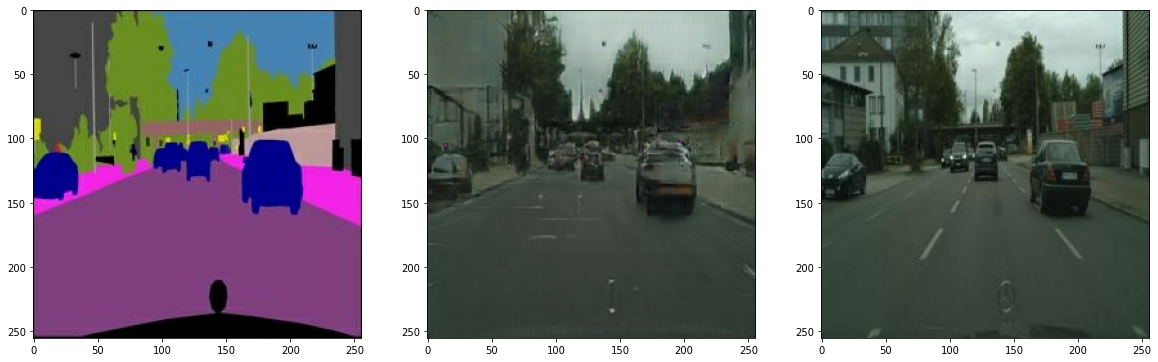

In [22]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

****************************
- EPOCHS = 500

In [ ]:
EPOCHS = 500

generator2 = UNetGenerator()
discriminator2 = Discriminator()
history = {'gen_loss2':[], 'l1_loss2':[], 'disc_loss2':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss2, l1_loss2, d_loss2 = train_step(input_image, real_image)
        history['gen_loss2'].append(g_loss2)
        history['l1_loss2'].append(l1_loss2)
        history['disc_loss2'].append(d_loss2)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss2.numpy():.4f} \
                    \nL1_loss:{l1_loss2.numpy():.4f} \

\nDiscriminator_loss:{d_loss2.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.7573                     
L1_loss:0.1185                     
Discriminator_loss:1.3675

EPOCH[1] - STEP[200]                     
Generator_loss:1.6115                     
L1_loss:0.1676                     
Discriminator_loss:0.3950

EPOCH[2] - STEP[100]                     
Generator_loss:1.4703                     
L1_loss:0.1546                     
Discriminator_loss:0.8878

EPOCH[2] - STEP[200]                     
Generator_loss:1.8387                     
L1_loss:0.1543                     
Discriminator_loss:0.8963

EPOCH[3] - STEP[100]                     
Generator_loss:0.6203                     
L1_loss:0.1498                     
Discriminator_loss:1.1880

EPOCH[3] - STEP[200]                     
Generator_loss:1.1750                     
L1_loss:0.1597                     
Discriminator_loss:0.5721

EPOCH[4] - STEP[100]                     
Generator_loss:1.8339                     
L1_loss:0.1524             

- EPOCHS = 20

In [59]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.3694                     
L1_loss:0.1777                     
Discriminator_loss:0.9994

EPOCH[1] - STEP[200]                     
Generator_loss:1.8120                     
L1_loss:0.1782                     
Discriminator_loss:0.6117

EPOCH[2] - STEP[100]                     
Generator_loss:1.6670                     
L1_loss:0.2037                     
Discriminator_loss:0.3716

EPOCH[2] - STEP[200]                     
Generator_loss:1.2277                     
L1_loss:0.2002                     
Discriminator_loss:1.0305

EPOCH[4] - STEP[100]                     
Generator_loss:3.3766                     
L1_loss:0.1384                     
Discriminator_loss:2.0787

EPOCH[4] - STEP[200]                     
Generator_loss:2.2475                     
L1_loss:0.1618                     
Discriminator_loss:0.7673

EPOCH[5] - STEP[100]                     
Generator_loss:2.6343                     
L1_loss:0.1893             

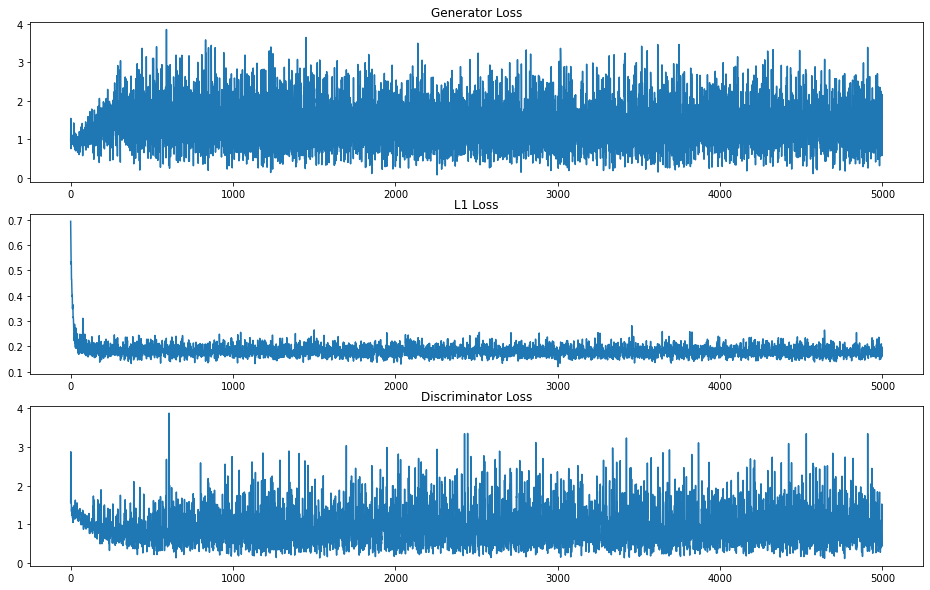

In [60]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

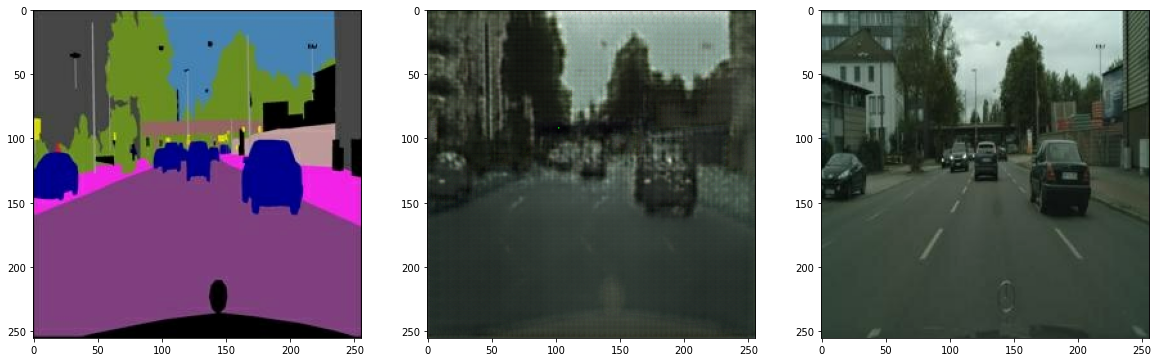

In [61]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

*******************************************

# 회고

- EPOCHS 300도 아쉬운 부분이 많이 보인다. 완전 세세한 부분은 확인이 어렵다.

- 아쉽게도...... EPOCHS 500을 해보려했지만, 도중에 커널 연결이 끊어져서 다음에는 무조건 check point를 만드는게 정답인 것 같다.

- EPOCHS 20과 300을 비교할 때 사진을 보면 무조건 EPOCH은 클수록 좋다.

- 데이터의 다양성 확보를 위해 Augmentation을 실행 했다. 너무 많이 하지 않고 적당한 변화가 좋다.